<left><a href="https://ubiqum.com/programs/data-analytics-and-machine-learning-program/"><img src = "https://scontent-ber1-1.cdninstagram.com/vp/706a70a2cf2361d0b5c0c9335e9d06d1/5D6D4095/t51.2885-19/s320x320/22352400_125994984820756_7444932873942990848_n.jpg?_nc_ht=scontent-ber1-1.cdninstagram.com" width = 40> </a></left>

<h1 align=center>IoT - Analytics</h1>
<h2 align=center>Deep Analytics, Visualitzation and Modelling</h2>

<h3 align=left><font color = #277a9a>Task 3: <font color = black>Evaluate Techniques for Wifi Locationing - Part 2 - RandomForest</h3>

### Index:

* [001 - Library import](#library_import)

* [002 - Data loading](#data_loading)

* [003 - Data modeling](#data_modeling)

    * [RandomForest](#index_RF)

### 001 - Library import <a id='library_import'></a>

In [1]:
import numpy as np
print ('Numpy: ', np.__version__)
import pandas as pd
print ('Pandas: ', pd.__version__)

%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
print ('Matplotlib: ', mpl.__version__)

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import ensemble # RandomForest
from sklearn import neighbors # knn
print ('scikit-learn: ', sk.__version__)

import math as math
from math import sqrt

import timeit

Numpy:  1.15.4
Pandas:  0.23.4
Matplotlib:  3.0.2
scikit-learn:  0.21.0


### 002 - Data loading  <a id='data_loading'></a>

In [2]:
df_train_clean = pd.read_csv("trainingData_clean.csv")
df_valid_clean = pd.read_csv("validationData_clean.csv")
print('Loading data...')
print ()
print ('dimensions (rows, column)')
print ('train:', df_train_clean.shape)
print ('valid:', df_valid_clean.shape)
print ()
print (df_train_clean.info())
print ()
print('...into the dataframe - ready!')

Loading data...

dimensions (rows, column)
train: (12373, 396)
valid: (1109, 379)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12373 entries, 0 to 12372
Columns: 396 entries, WAP001 to ABSOLUTE_LATITUDE
dtypes: float64(4), int64(391), object(1)
memory usage: 37.4+ MB
None

...into the dataframe - ready!


In [3]:
df_train_clean.head()

,WAP001,WAP002,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,...,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,WAP_COUNT,ABSOLUTE_LONGITUDE,ABSOLUTE_LATITUDE
0,0,0,0,0,0,0,0,0,0,0,...,2,1,106,2,2,23,2013-06-20 07:35:33,17,150.0741,175.033184
1,0,0,0,0,0,0,0,0,0,0,...,2,1,106,2,2,23,2013-06-20 07:34:51,16,154.7172,188.480184
2,0,0,0,0,0,8,0,0,0,0,...,2,1,103,2,2,23,2013-06-20 07:41:35,15,172.1860,203.787184
3,0,0,0,0,0,0,0,0,0,0,...,2,1,102,2,2,23,2013-06-20 07:36:47,16,166.7680,188.347984
4,0,0,0,0,0,0,0,0,0,0,...,2,1,105,2,2,23,2013-06-20 07:37:21,15,157.4422,193.513284


In [4]:
df_valid_clean.head()

,WAP001,WAP003,WAP004,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,...,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,WAP_COUNT,ABSOLUTE_LONGITUDE,ABSOLUTE_LATITUDE
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,2013-10-04 07:45:03,1,180.021956,141.647431
1,0,0,0,0,0,0,18,18,0,0,...,4,2,0,0,0,13,2013-10-07 14:10:54,12,312.071534,91.724822
2,0,0,0,0,0,0,32,33,0,0,...,4,2,0,0,0,13,2013-10-07 14:11:35,10,321.636675,98.518237
3,0,0,0,0,0,0,28,30,0,0,...,4,2,0,0,0,13,2013-10-07 14:12:18,10,330.113872,94.813768
4,0,0,0,0,0,0,0,0,26,26,...,2,0,0,0,0,2,2013-10-04 09:09:34,14,54.439452,174.383692


### 003 - Data modeling <a id='data_modeling'></a>

In [5]:
# remove unnecessary colums
print ('remove unnecessary colums')
print ('dimensions (rows, column)')
# Training dataset
df_train = df_train_clean.drop(['LONGITUDE', 'LATITUDE', 'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP', 'WAP_COUNT'], axis=1)
print ('train:', df_train.shape)
# Test dataset
df_valid = df_valid_clean.drop(['LONGITUDE', 'LATITUDE', 'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP', 'WAP_COUNT'], axis=1)
print ('test:', df_valid.shape)

remove unnecessary colums
dimensions (rows, column)
train: (12373, 388)
test: (1109, 371)


### RandomForest <a id='index_RF'></a>

#### RandomForest - SPLITTING

In [6]:
# prepare X and y dataset
# (FLOOR (FL)= 384, BUILDINGID (BLDG) = 385, ABSOLUTE_LONGITUDE (LON) = 386, ABSOLUTE_LATITUDE (LAT) = 387)
X_RF_ALL_FL = df_train.iloc[:, :-4].values
y_RF_ALL_FL = df_train.iloc[:, 384].values

X_RF_ALL_BLDG = df_train.iloc[:, :-4].values
y_RF_ALL_BLDG = df_train.iloc[:, 385].values

X_RF_ALL_LON = df_train.iloc[:, :-4].values
y_RF_ALL_LON = df_train.iloc[:, 386].values

X_RF_ALL_LAT = df_train.iloc[:, :-4].values
y_RF_ALL_LAT = df_train.iloc[:, 387].values

#spliting the dataset into training and test set
X_RF_ALL_FL_train, X_RF_ALL_FL_test, y_RF_ALL_FL_train, y_RF_ALL_FL_test = train_test_split(X_RF_ALL_FL, y_RF_ALL_FL, test_size=0.3, random_state=0)
X_RF_ALL_BLDG_train, X_RF_ALL_BLDG_test, y_RF_ALL_BLDG_train, y_RF_ALL_BLDG_test = train_test_split(X_RF_ALL_BLDG, y_RF_ALL_BLDG, test_size=0.3, random_state=0)
X_RF_ALL_LON_train, X_RF_ALL_LON_test, y_RF_ALL_LON_train, y_RF_ALL_LON_test = train_test_split(X_RF_ALL_LON, y_RF_ALL_LON, test_size=0.3, random_state=0)
X_RF_ALL_LAT_train, X_RF_ALL_LAT_test, y_RF_ALL_LAT_train, y_RF_ALL_LAT_test = train_test_split(X_RF_ALL_LAT, y_RF_ALL_LAT, test_size=0.3, random_state=0)

#### RandomForest - FLOOR

In [7]:
RF_ALL_FL_start = timeit.default_timer()

RF_ALL_FL_rmse_val = [] # to store rmse values for different tree
RF_ALL_FL_r2_val = [] # to store r2 values for different tree

for RF_ALL_FL in range(10):
    RF_ALL_FL = (RF_ALL_FL + 1)*20
    RF_ALL_FL_model = ensemble.RandomForestRegressor(n_estimators = RF_ALL_FL)

    RF_ALL_FL_model.fit(X_RF_ALL_FL_train, y_RF_ALL_FL_train)  #fit the model
    RF_ALL_FL_pred = RF_ALL_FL_model.predict(X_RF_ALL_FL_test) #make prediction on test set
    RF_ALL_FL_error = sqrt(mean_squared_error(y_RF_ALL_FL_test, RF_ALL_FL_pred)) #calculate rmse
    RF_ALL_FL_r2 = r2_score(y_RF_ALL_FL_test, RF_ALL_FL_pred)
    RF_ALL_FL_rmse_val.append(RF_ALL_FL_error) #store rmse values
    RF_ALL_FL_r2_val.append(RF_ALL_FL_r2) #store r2 values

    print('Value (RF_ALL_FL) for number of trees=', RF_ALL_FL, 'is:')    
    print('RMSE   :', RF_ALL_FL_error)
    print('Rsqaure:', RF_ALL_FL_r2)

RF_ALL_FL_stop = timeit.default_timer()
print ()
RF_ALL_FL_t = (RF_ALL_FL_stop - RF_ALL_FL_start)/60
print ('Time in min: ', round(RF_ALL_FL_t, 3))

Value (RF_ALL_FL) for number of trees= 20 is:
RMSE   : 0.17546845022583385
Rsqaure: 0.9796633032640966
Value (RF_ALL_FL) for number of trees= 40 is:
RMSE   : 0.1702500952729321
Rsqaure: 0.9808549255735836
Value (RF_ALL_FL) for number of trees= 60 is:
RMSE   : 0.17023006022765463
Rsqaure: 0.9808594312963316
Value (RF_ALL_FL) for number of trees= 80 is:
RMSE   : 0.16988950410768372
Rsqaure: 0.9809359385539479
Value (RF_ALL_FL) for number of trees= 100 is:
RMSE   : 0.17140888473279392
Rsqaure: 0.980593420747587
Value (RF_ALL_FL) for number of trees= 120 is:
RMSE   : 0.17039449026916229
Rsqaure: 0.9808224366018824
Value (RF_ALL_FL) for number of trees= 140 is:
RMSE   : 0.1677868394089287
Rsqaure: 0.981404917117097
Value (RF_ALL_FL) for number of trees= 160 is:
RMSE   : 0.17074937283713945
Rsqaure: 0.9807424707511464
Value (RF_ALL_FL) for number of trees= 180 is:
RMSE   : 0.17033664747760272
Rsqaure: 0.9808354545758738
Value (RF_ALL_FL) for number of trees= 200 is:
RMSE   : 0.17080046792964

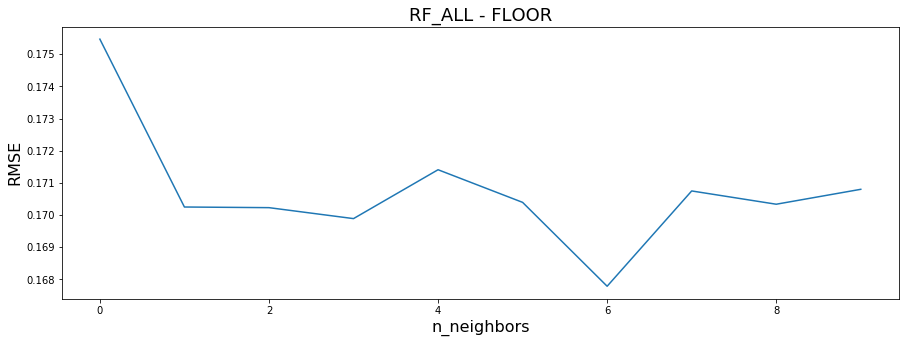

In [8]:
# plotting the rmse values against k values
RF_ALL_FL_curveRMSE = pd.DataFrame(RF_ALL_FL_rmse_val)
RF_ALL_FL_curveRMSE.plot(legend=None, figsize=(15,5))

plt.title('RF_ALL - FLOOR', fontsize=18)
plt.ylabel('RMSE', fontsize=16)
plt.xlabel('n_neighbors', fontsize=16)

plt.savefig('./rf/01_RF_ALL_FL_RMSE.png', bbox_inches='tight')

plt.show()

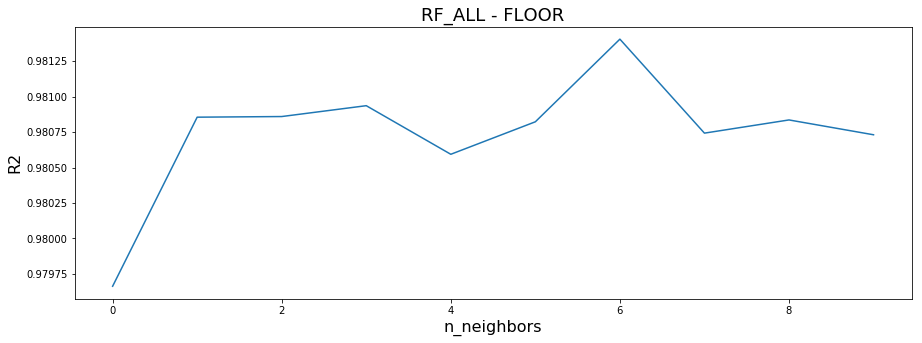

In [9]:
# plotting the r2 values against k values
RF_ALL_FL_curveR2 = pd.DataFrame(RF_ALL_FL_r2_val)
RF_ALL_FL_curveR2.plot(legend=None, figsize=(15,5))

plt.title('RF_ALL - FLOOR', fontsize=18)
plt.ylabel('R2', fontsize=16)
plt.xlabel('n_neighbors', fontsize=16)

plt.savefig('./rf/02_RF_ALL_FL_r2.png', bbox_inches='tight')

plt.show()

#### KNN_ALL - BUILDINGID

In [10]:
RF_ALL_BLDG_start = timeit.default_timer()

RF_ALL_BLDG_rmse_val = [] # to store rmse values for different tree
RF_ALL_BLDG_r2_val = [] # to store r2 values for different tree

for RF_ALL_BLDG in range(10):
    RF_ALL_BLDG = (RF_ALL_BLDG + 1)*20
    RF_ALL_BLDG_model = ensemble.RandomForestRegressor(n_estimators = RF_ALL_BLDG)

    RF_ALL_BLDG_model.fit(X_RF_ALL_BLDG_train, y_RF_ALL_BLDG_train)  #fit the model
    RF_ALL_BLDG_pred = RF_ALL_BLDG_model.predict(X_RF_ALL_BLDG_test) #make prediction on test set
    RF_ALL_BLDG_error = sqrt(mean_squared_error(y_RF_ALL_BLDG_test, RF_ALL_BLDG_pred)) #calculate rmse
    RF_ALL_BLDG_r2 = r2_score(y_RF_ALL_BLDG_test, RF_ALL_BLDG_pred)
    RF_ALL_BLDG_rmse_val.append(RF_ALL_BLDG_error) #store rmse values
    RF_ALL_BLDG_r2_val.append(RF_ALL_BLDG_r2) #store r2 values

    print('Value (RF_ALL_BLDG) for number of trees=', RF_ALL_BLDG, 'is:')    
    print('RMSE   :', RF_ALL_BLDG_error)
    print('Rsqaure:', RF_ALL_BLDG_r2)

RF_ALL_BLDG_stop = timeit.default_timer()
print ()
RF_ALL_BLDG_t = (RF_ALL_BLDG_stop - RF_ALL_BLDG_start)/60
print ('Time in min: ', round(RF_ALL_BLDG_t, 3))

Value (RF_ALL_BLDG) for number of trees= 20 is:
RMSE   : 0.04139379426111323
Rsqaure: 0.9974690640355163
Value (RF_ALL_BLDG) for number of trees= 40 is:
RMSE   : 0.0421325317840857
Rsqaure: 0.9973779208461775
Value (RF_ALL_BLDG) for number of trees= 60 is:
RMSE   : 0.04119941453636474
Rsqaure: 0.9974927780993997
Value (RF_ALL_BLDG) for number of trees= 80 is:
RMSE   : 0.03978473865958166
Rsqaure: 0.9976620043284509
Value (RF_ALL_BLDG) for number of trees= 100 is:
RMSE   : 0.04103550855111427
Rsqaure: 0.9975126876651144
Value (RF_ALL_BLDG) for number of trees= 120 is:
RMSE   : 0.041027333478772875
Rsqaure: 0.9975136786084964
Value (RF_ALL_BLDG) for number of trees= 140 is:
RMSE   : 0.04014936044987767
Rsqaure: 0.9976189531159604
Value (RF_ALL_BLDG) for number of trees= 160 is:
RMSE   : 0.04092552299980191
Rsqaure: 0.9975260030503393
Value (RF_ALL_BLDG) for number of trees= 180 is:
RMSE   : 0.0415114105297467
Rsqaure: 0.9974546608061285
Value (RF_ALL_BLDG) for number of trees= 200 is:
RM

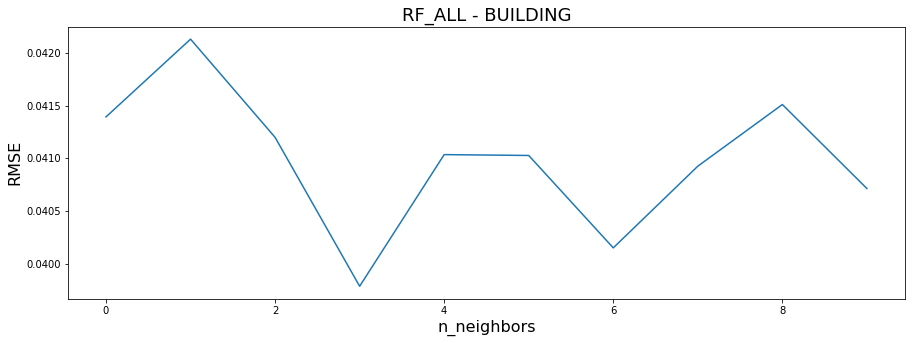

In [11]:
# plotting the rmse values against k values
RF_ALL_BLDG_curveRMSE = pd.DataFrame(RF_ALL_BLDG_rmse_val)
RF_ALL_BLDG_curveRMSE.plot(legend=None, figsize=(15,5))

plt.title('RF_ALL - BUILDING', fontsize=18)
plt.ylabel('RMSE', fontsize=16)
plt.xlabel('n_neighbors', fontsize=16)

plt.savefig('./rf/03_RF_ALL_BLDG_RMSE.png', bbox_inches='tight')

plt.show()

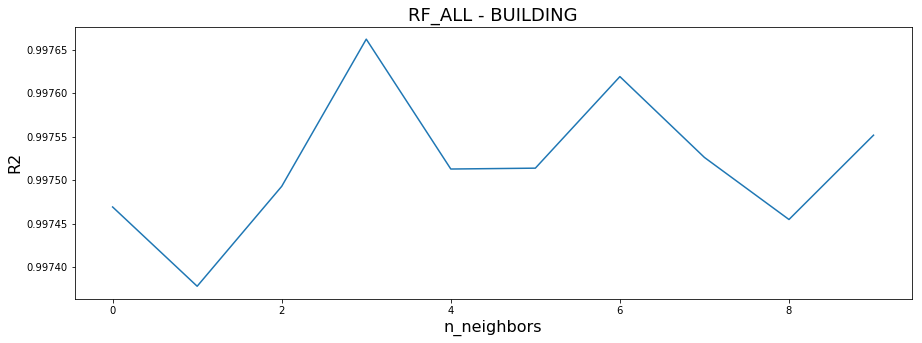

In [12]:
# plotting the r2 values against k values
RF_ALL_BLDG_curveR2 = pd.DataFrame(RF_ALL_BLDG_r2_val)
RF_ALL_BLDG_curveR2.plot(legend=None, figsize=(15,5))

plt.title('RF_ALL - BUILDING', fontsize=18)
plt.ylabel('R2', fontsize=16)
plt.xlabel('n_neighbors', fontsize=16)

plt.savefig('./rf/04_RF_ALL_BLDG_r2.png', bbox_inches='tight')

plt.show()

#### KNN_ALL - ABSOLUTE_LONGITUDE

In [13]:
RF_ALL_LON_start = timeit.default_timer()

RF_ALL_LON_rmse_val = [] # to store rmse values for different tree
RF_ALL_LON_r2_val = [] # to store r2 values for different tree

for RF_ALL_LON in range(10):
    RF_ALL_LON = (RF_ALL_LON + 1)*20
    RF_ALL_LON_model = ensemble.RandomForestRegressor(n_estimators = RF_ALL_LON)

    RF_ALL_LON_model.fit(X_RF_ALL_LON_train, y_RF_ALL_LON_train)  #fit the model
    RF_ALL_LON_pred = RF_ALL_LON_model.predict(X_RF_ALL_LON_test) #make prediction on test set
    RF_ALL_LON_error = sqrt(mean_squared_error(y_RF_ALL_LON_test, RF_ALL_LON_pred)) #calculate rmse
    RF_ALL_LON_r2 = r2_score(y_RF_ALL_LON_test, RF_ALL_LON_pred)
    RF_ALL_LON_rmse_val.append(RF_ALL_LON_error) #store rmse values
    RF_ALL_LON_r2_val.append(RF_ALL_LON_r2) #store r2 values

    print('Value (RF_ALL_LON) for number of trees=', RF_ALL_LON, 'is:')    
    print('RMSE   :', RF_ALL_LON_error)
    print('Rsqaure:', RF_ALL_LON_r2)

RF_ALL_LON_stop = timeit.default_timer()
print ()
RF_ALL_LON_t = (RF_ALL_LON_stop - RF_ALL_LON_start)/60
print ('Time in min: ', round(RF_ALL_LON_t, 3))

Value (RF_ALL_LON) for number of trees= 20 is:
RMSE   : 8.17386184594087
Rsqaure: 0.995412830314479
Value (RF_ALL_LON) for number of trees= 40 is:
RMSE   : 8.102183163753983
Rsqaure: 0.9954929296869955
Value (RF_ALL_LON) for number of trees= 60 is:
RMSE   : 8.109510084430056
Rsqaure: 0.995484774384268
Value (RF_ALL_LON) for number of trees= 80 is:
RMSE   : 7.846114054260196
Rsqaure: 0.995773319177468
Value (RF_ALL_LON) for number of trees= 100 is:
RMSE   : 8.01673537594723
Rsqaure: 0.9955874939285294
Value (RF_ALL_LON) for number of trees= 120 is:
RMSE   : 8.010072164422448
Rsqaure: 0.9955948259012668
Value (RF_ALL_LON) for number of trees= 140 is:
RMSE   : 8.083277723184429
Rsqaure: 0.9955139385279203
Value (RF_ALL_LON) for number of trees= 160 is:
RMSE   : 7.933915875407805
Rsqaure: 0.9956781926669405
Value (RF_ALL_LON) for number of trees= 180 is:
RMSE   : 7.939954524642165
Rsqaure: 0.9956716113492808
Value (RF_ALL_LON) for number of trees= 200 is:
RMSE   : 7.940391007278254
Rsqaure

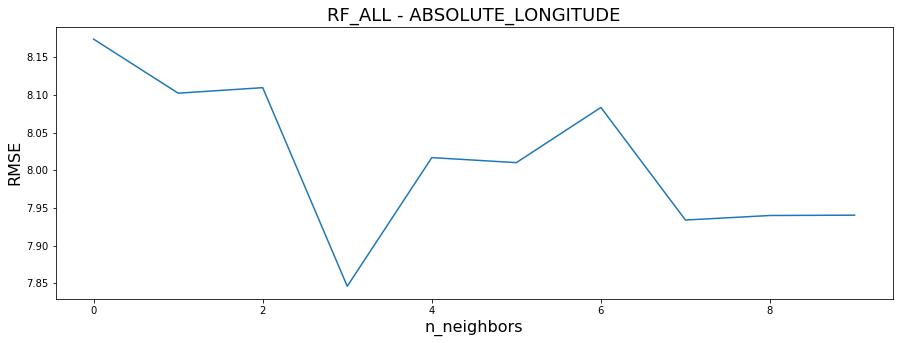

In [14]:
# plotting the rmse values against k values
RF_ALL_LON_curveRMSE = pd.DataFrame(RF_ALL_LON_rmse_val)
RF_ALL_LON_curveRMSE.plot(legend=None, figsize=(15,5))

plt.title('RF_ALL - ABSOLUTE_LONGITUDE', fontsize=18)
plt.ylabel('RMSE', fontsize=16)
plt.xlabel('n_neighbors', fontsize=16)

plt.savefig('./rf/05_RF_ALL_LON_RMSE.png', bbox_inches='tight')

plt.show()

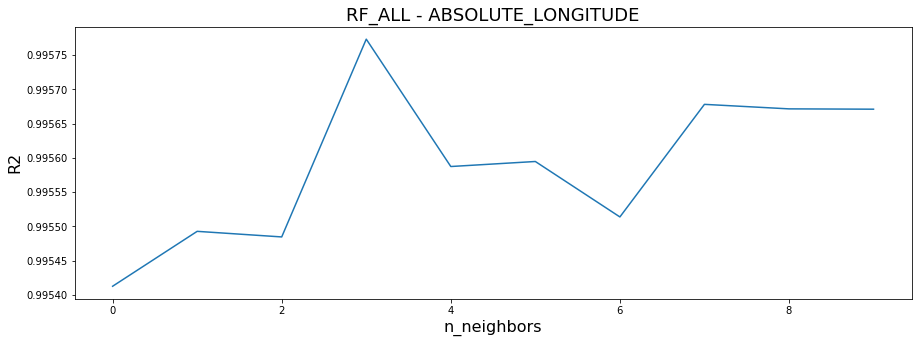

In [15]:
# plotting the r2 values against k values
RF_ALL_LON_curveR2 = pd.DataFrame(RF_ALL_LON_r2_val)
RF_ALL_LON_curveR2.plot(legend=None, figsize=(15,5))

plt.title('RF_ALL - ABSOLUTE_LONGITUDE', fontsize=18)
plt.ylabel('R2', fontsize=16)
plt.xlabel('n_neighbors', fontsize=16)

plt.savefig('./rf/06_RF_ALL_LON_r2.png', bbox_inches='tight')

plt.show()

#### KNN_ALL - ABSOLUTE_LATITUDE

In [16]:
RF_ALL_LAT_start = timeit.default_timer()

RF_ALL_LAT_rmse_val = [] # to store rmse values for different tree
RF_ALL_LAT_r2_val = [] # to store r2 values for different tree

for RF_ALL_LAT in range(10):
    RF_ALL_LAT = (RF_ALL_LAT + 1)*20
    RF_ALL_LAT_model = ensemble.RandomForestRegressor(n_estimators = RF_ALL_LAT)

    RF_ALL_LAT_model.fit(X_RF_ALL_LAT_train, y_RF_ALL_LAT_train)  #fit the model
    RF_ALL_LAT_pred = RF_ALL_LAT_model.predict(X_RF_ALL_LAT_test) #make prediction on test set
    RF_ALL_LAT_error = sqrt(mean_squared_error(y_RF_ALL_LAT_test, RF_ALL_LAT_pred)) #calculate rmse
    RF_ALL_LAT_r2 = r2_score(y_RF_ALL_LAT_test, RF_ALL_LAT_pred)
    RF_ALL_LAT_rmse_val.append(RF_ALL_LAT_error) #store rmse values
    RF_ALL_LAT_r2_val.append(RF_ALL_LAT_r2) #store r2 values

    print('Value (RF_ALL_LAT) for number of trees=', RF_ALL_LAT, 'is:')    
    print('RMSE   :', RF_ALL_LAT_error)
    print('Rsqaure:', RF_ALL_LAT_r2)

RF_ALL_LAT_stop = timeit.default_timer()
print ()
RF_ALL_LAT_t = (RF_ALL_LAT_stop - RF_ALL_LAT_start)/60
print ('Time in min: ', round(RF_ALL_LAT_t, 3))

Value (RF_ALL_LAT) for number of trees= 20 is:
RMSE   : 5.8803068430360295
Rsqaure: 0.9926671086127079
Value (RF_ALL_LAT) for number of trees= 40 is:
RMSE   : 5.789120395104208
Rsqaure: 0.9928927688880945
Value (RF_ALL_LAT) for number of trees= 60 is:
RMSE   : 5.752423645470957
Rsqaure: 0.9929825875926115
Value (RF_ALL_LAT) for number of trees= 80 is:
RMSE   : 5.844893056025352
Rsqaure: 0.9927551664269753
Value (RF_ALL_LAT) for number of trees= 100 is:
RMSE   : 5.745913975979548
Rsqaure: 0.9929984609673975
Value (RF_ALL_LAT) for number of trees= 120 is:
RMSE   : 5.775240923134396
Rsqaure: 0.9929268073456039
Value (RF_ALL_LAT) for number of trees= 140 is:
RMSE   : 5.786267350427753
Rsqaure: 0.9928997724568234
Value (RF_ALL_LAT) for number of trees= 160 is:
RMSE   : 5.740381182820309
Rsqaure: 0.99301193816765
Value (RF_ALL_LAT) for number of trees= 180 is:
RMSE   : 5.747714545114593
Rsqaure: 0.9929940722033501
Value (RF_ALL_LAT) for number of trees= 200 is:
RMSE   : 5.7326514637161035
Rs

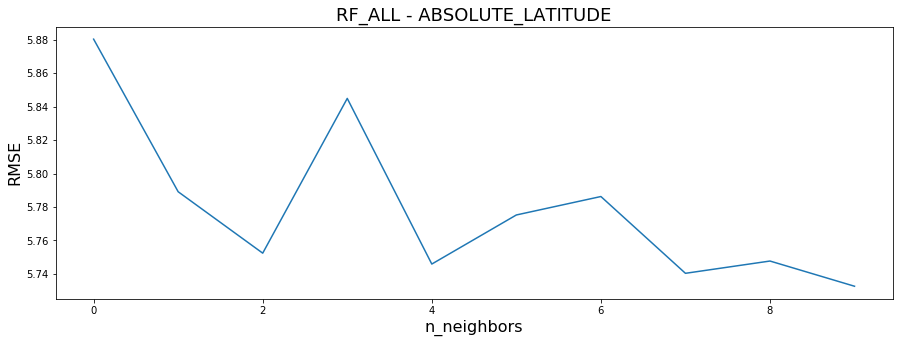

In [17]:
# plotting the rmse values against k values
RF_ALL_LAT_curveRMSE = pd.DataFrame(RF_ALL_LAT_rmse_val)
RF_ALL_LAT_curveRMSE.plot(legend=None, figsize=(15,5))

plt.title('RF_ALL - ABSOLUTE_LATITUDE', fontsize=18)
plt.ylabel('RMSE', fontsize=16)
plt.xlabel('n_neighbors', fontsize=16)

plt.savefig('./rf/07_RF_ALL_LAT_RMSE.png', bbox_inches='tight')

plt.show()

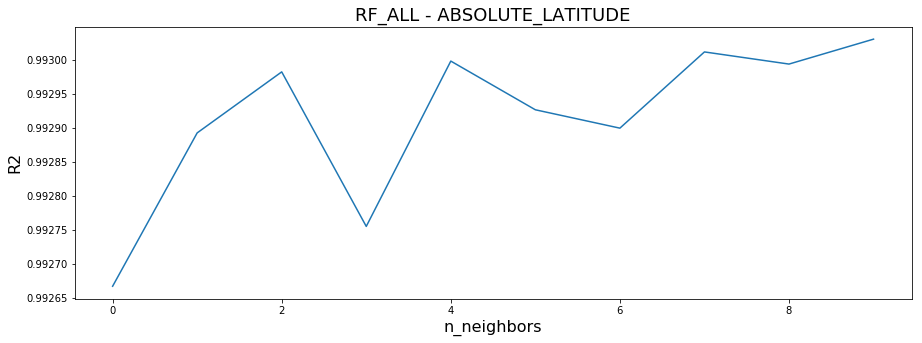

In [18]:
# plotting the r2 values against k values
RF_ALL_LAT_curveR2 = pd.DataFrame(RF_ALL_LAT_r2_val)
RF_ALL_LAT_curveR2.plot(legend=None, figsize=(15,5))

plt.title('RF_ALL - ABSOLUTE_LATITUDE', fontsize=18)
plt.ylabel('R2', fontsize=16)
plt.xlabel('n_neighbors', fontsize=16)

plt.savefig('./rf/08_RF_ALL_LAT_r2.png', bbox_inches='tight')

plt.show()

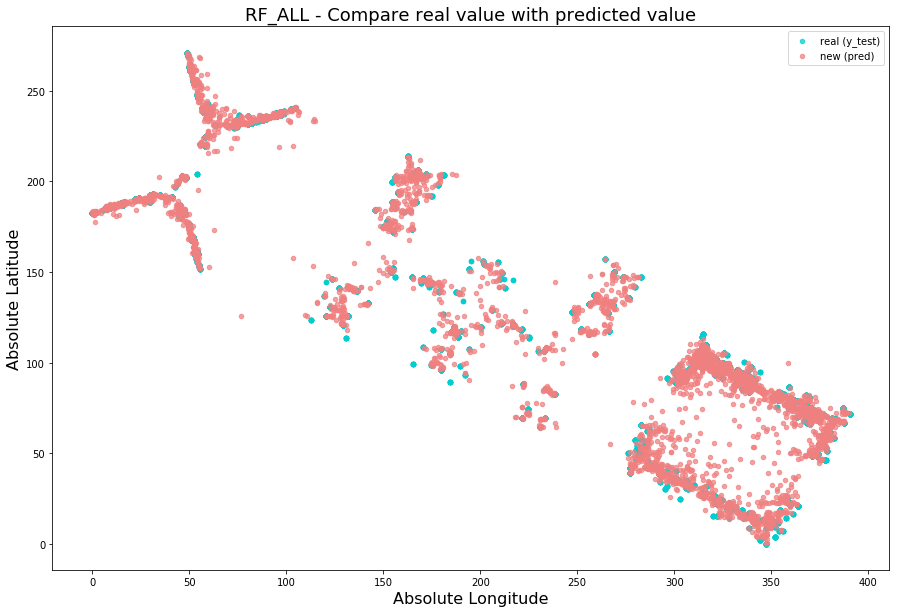

In [19]:
REAL_ALL = pd.DataFrame()
REAL_ALL['ABSOLUTE_LONGITUDE'] = y_RF_ALL_LON
REAL_ALL['ABSOLUTE_LATITUDE'] = y_RF_ALL_LAT
ax1 = REAL_ALL.plot(kind='scatter', x="ABSOLUTE_LONGITUDE", y="ABSOLUTE_LATITUDE",
                    label = 'real (y_test)',
                    color="darkturquoise",
                    figsize=(15,10),
                    alpha=0.75)

NEW_ALL = pd.DataFrame()
NEW_ALL['ABSOLUTE_LONGITUDE'] = RF_ALL_LON_pred
NEW_ALL['ABSOLUTE_LATITUDE'] = RF_ALL_LAT_pred
ax2 = NEW_ALL.plot(kind='scatter', x="ABSOLUTE_LONGITUDE", y="ABSOLUTE_LATITUDE",
                   label = 'new (pred)',
                   color="lightcoral",
                   figsize=(15,10),
                   alpha=0.75,
                   ax=ax1)

plt.title("RF_ALL - Compare real value with predicted value", fontsize=18)
plt.xlabel('Absolute Longitude', fontsize=16)
plt.ylabel('Absolute Latitude', fontsize=16)
plt.legend(loc='best')

plt.savefig('./RF/09_RF_ALL_REAL_NEW.png', bbox_inches='tight')

plt.show()